In [1]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

In [2]:
import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [3]:
case = "1" # Case 1 is for anomalous density diffusion only.
filepath = "circle_cut/BOUT.dmp.*.nc"
#filepath = "test" + str(case) + "/BOUT.dmp.0.nc"

ds = open_boutdataset(datapath=filepath, chunks={"t": 4})
dsn = xr.open_dataset("circle_cut_lowestres.fci.nc")

# Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
ds = ds.squeeze(drop=True)
dsn = dsn.squeeze(drop=True)

for key,val in ds.items():
    print(key)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 46MB
Dimensions:             (x: 68, y: 1, z: 68, t: 201)
Coordinates:
    dx                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dy                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dz                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 544B 0 1 2 3 4 5 6 7 ... 61 62 63 64 65 66 67
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 544B 0.007353 0.02206 ... 0.9779 0.9926
Data variables: (12/52)
    Bxy                 (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G1                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G2                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [4]:
dx = ds["dx"].isel(z=0).values

# Get rid of existing "x" coordinate, which is just the index values.
#ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

#Store just initial values as well.
ds_initial = ds.isel(t=0)

In [5]:
dens = ds["Nh+"]
src = ds["SNh+"]
dens_true = dens.copy()

mask = dsn["in_mask"]
vols = dsn["vol_frac"]
ghost_id = dsn["ghost_id"].values
#Get mask of ghost and inside cells.
ghost_mask = (ghost_id >= 0).astype(bool)
full_mask = ghost_mask | mask.astype(bool)
#For cut cells, need to ignore ghost cells with vol 1 because BOUT runs all cells and 1 outside to not div by 0...
full_ghost_mask = ghost_mask & (vols >= 1).astype(bool)
full_mask = full_mask & ~full_ghost_mask
vols = np.where(full_mask, vols, 0)

gst_pts = dsn["ghost_pts"].values
bdy_pts = dsn["bndry_pts"].values
img_pts = dsn["image_pts"].values
normals = dsn["normals"].values
is_plasma = dsn["is_plasma"].values
Rarr = dsn["R"].values
Zarr = dsn["Z"].values

timestep_for_errs_early = 10
timestep_for_errs_late = 100
spl_e = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_early,:,:], kx=1, ky=1)
spl_l = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_late,:,:], kx=1, ky=1)

In [6]:
beta0 = 3.8317059702075125

x_unit = 0.00022846974366979959 #rho_s0
w_unit = 95788333.030660808    #Omega_ci
t_unit = 1/w_unit

nx = 64*int(case)
nz = nx + 4
dx = np.float64(1.0) / np.float64(nx)
dz = np.float64(1.0) / np.float64(nz)

# Centers in x; faces/nodes in z if that's your convention
x = (np.arange(nx, dtype=np.float64) + 0.5) * dx     # centered x
z = (np.arange(nz, dtype=np.float64)) * dz           # unshifted z

ghosts_lo_x = x[0]  - dx*np.arange(2, 0, -1)
ghosts_hi_x = x[-1] + dx*np.arange(1, 2+1)
x = np.concatenate((ghosts_lo_x, x, ghosts_hi_x))
xx,zz = np.meshgrid(x,z,indexing='ij')

R_min, R_max = dsn["R"].values[2,0], dsn["R"].values[-3,0]
Z_min, Z_max = dsn["Z"].values[0,0], dsn["Z"].values[0,-1]
dR = dsn["R"].values[1,0] - dsn["R"].values[0,0]
dZ = dsn["Z"].values[0,1] - dsn["Z"].values[0,0]
R0, Z0, a = 2.5, -0.022058823529411686, 1.0

x0 = (x[-1]+x[0])/2
z0 = (z[-1]+z[0])/2
print(x0)
print(z0)

# with:
D = 1
t64 = np.asarray(ds["t_array"].values, dtype=np.float64) # 1D time
t_norm = t64*t_unit

rho = np.hypot((xx - x0), (zz - z0)) #(R_max-R_min)*, (Z_max-Z_min)*
spatial = j0(beta0 * rho / (1/3))
temp    = np.exp(-D * (beta0 / a)**2 * t_norm)

dens_true = dens.copy()
dens_true[:] = 1 + spatial[np.newaxis,:,:] * temp[:,np.newaxis,np.newaxis]

#R,Z = dsn["R"].values[:,0], dsn["Z"].values[0,:]
#RR, ZZ = np.meshgrid(R,Z, indexing="ij")
#rmid = (R[-1] + R[0])/2
#zmid = (Z[-1] + Z[0])/2
#rho = np.hypot(RR-R0, ZZ-Z0)
##rho = np.hypot(xx-x0, zz - z0)
#
#eps = 0.1
#f = 1.0 + eps * (1.0 - 2.0 * (rho**2) / 1)
#
## Only inside the disk; outside = 0 or masked
#f_disk = np.where(rho <= a, f, 0.0)
#
#dens_true[0,:,:] = f_disk

0.5
0.4926470588235294


In [7]:
bdy_pts_xz_e = spl_e.ev(bdy_pts[:,0], bdy_pts[:,1])
bdy_pts_xz_l = spl_l.ev(bdy_pts[:,0], bdy_pts[:,1])
print("Linf bdy err if dirichlet: " + str(np.max(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (early) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (late) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_l))))

#dndR = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=1, dy=0) # ∂n/∂R at boundary points
#dndZ = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=0, dy=1) # ∂n/∂Z at boundary points
#dn_dn = dndR * normals[:,0] + dndZ * normals[:,1]     # normal derivative
dP = np.einsum('ij,ij->i', (bdy_pts - img_pts), -normals)
dG = np.einsum('ij,ij->i', (gst_pts - bdy_pts), -normals)
dn_dn_e = (spl_e.ev(img_pts[:,0], img_pts[:,1]) - spl_e.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)
dn_dn_l = (spl_l.ev(img_pts[:,0], img_pts[:,1]) - spl_l.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)

Linf = np.max(np.abs(dn_dn_e))
L2   = np.sqrt(np.mean(dn_dn_e**2))
L2   = np.sqrt(np.mean(dn_dn_l**2))
print("Linf bdy err if neumann: " + str(np.max(np.abs(dn_dn_e))))
print("L2 bdy err (early) if neumann: " + str(np.sqrt(np.mean(dn_dn_e**2))))
print("L2 bdy err (late) if neumann: " + str(np.sqrt(np.mean(dn_dn_l**2))))

Linf bdy err if dirichlet: 0.8250732171300543
L2 bdy err (early) if dirichlet?: 0.82105593337206
L2 bdy err (late) if dirichlet?: 1.005824932819282
Linf bdy err if neumann: 0.0021312671384056707
L2 bdy err (early) if neumann: 0.00033697090560972867
L2 bdy err (late) if neumann: 3.037786681185808e-07


In [8]:
M0 = (dens.where(mask)*vols*dR*dZ)[0,:,:].sum().values
M1 = (dens.where(mask)*vols*dR*dZ)[10,:,:].sum().values
M2 = (dens.where(mask)*vols*dR*dZ)[100,:,:].sum().values
M3 = (dens.where(mask)*vols*dR*dZ)[-1,:,:].sum().values
print(M0)
print(M1)
print(M2)
print(M3)
print("ΔM =", M3 - M0)
print("relative change =", (M3 - M0)/M0)
assert np.isclose(M3, M0, rtol=1e-10, atol=1e-14)

3.12016550310849
3.1224384933312166
3.124346664190731
3.1243486157716123
ΔM = 0.004183112663122213
relative change = 0.0013406701211697754


AssertionError: 

In [9]:
M0_true = (dens_true.where(mask)*vols*dR*dZ)[0,:,:].sum().values
M1_true = (dens_true.where(mask)*vols*dR*dZ)[10,:,:].sum().values
M2_true = (dens_true.where(mask)*vols*dR*dZ)[100,:,:].sum().values
M3_true = (dens_true.where(mask)*vols*dR*dZ)[-1,:,:].sum().values
print(M0_true)
print(M1_true)
print(M2_true)
print(M3_true)
print("ΔM =", M3_true - M0_true)
print("relative change =", (M3_true - M0_true)/M0_true)
#assert np.isclose(M3_true, M0_true, rtol=1e-10, atol=1e-14)

print("vol diff: ", M0_true - M0)

3.12016550310849
3.112436072501838
3.105733002429293
3.105726225794198
ΔM = -0.014439277314291843
relative change = -0.004627728016320479
vol diff:  0.0


In [10]:
dens_masked      = dens.values[0,:,:][ghost_mask]
dens_true_masked = dens_true.values[0,:,:][ghost_mask]

l2 = np.sqrt(np.mean((dens_masked - dens_true_masked)**2))
print("Boundary Linf norm: ", np.max(dens_masked-dens_true_masked))
print("Boundary L2 norm: ", l2)

dens_masked      = dens.values[10,:,:][ghost_mask]
dens_true_masked = dens_true.values[10,:,:][ghost_mask]

l2 = np.sqrt(np.mean((dens_masked - dens_true_masked)**2))
print("Boundary Linf norm: ", np.max(dens_masked-dens_true_masked))
print("Boundary L2 norm: ", l2)

dens_masked      = dens.values[100,:,:][ghost_mask]
dens_true_masked = dens_true.values[100,:,:][ghost_mask]

l2 = np.sqrt(np.mean((dens_masked - dens_true_masked)**2))
print("Boundary Linf norm: ", np.max(dens_masked-dens_true_masked))
print("Boundary L2 norm: ", l2)

Boundary Linf norm:  0.004312956981242344
Boundary L2 norm:  0.0019781902555189176
Boundary Linf norm:  0.012144296426313983
Boundary L2 norm:  0.007968998783498044
Boundary Linf norm:  0.006078911203350135
Boundary L2 norm:  0.006013664301348071


In [ ]:
R,Z = dsn["R"].values[:,0], dsn["Z"].values[0,:]

x_edges = np.concatenate(([R[0] - 0.5*dR],
                          0.5*(R[:-1] + R[1:]),
                          [R[-1] + 0.5*dR]))
z_edges = np.concatenate(([Z[0] - 0.5*dZ],
                          0.5*(Z[:-1] + Z[1:]),
                          [Z[-1] + 0.5*dZ]))
xxe, zze = np.meshgrid(x_edges, z_edges, indexing='ij')

In [ ]:
plt.close('all')      # optional, but guarantees a clean slate for the whole kernel
fig, ax = plt.subplots()  # new figure/axes each run
ax.pcolormesh(xxe,zze,vols)
plt.show()

0
0.005996145246603507


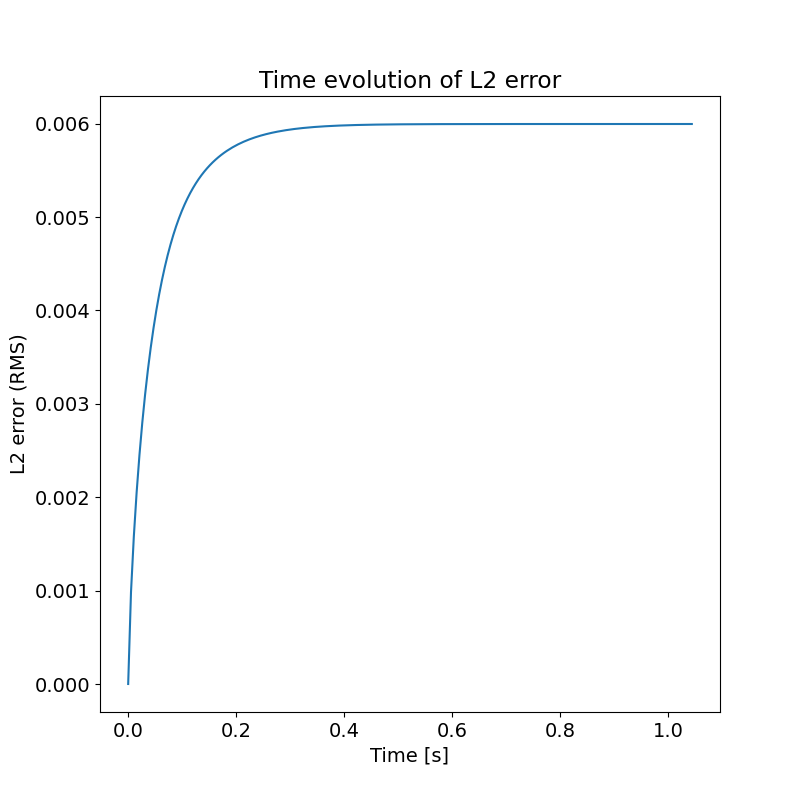

In [11]:

dens_diff = np.abs(dens.where(mask)-dens_true.where(mask)) # np.abs(dens.where(mask) - dens_true.where(mask))
l2_err_t = np.sqrt(np.nanmean(dens_diff**2, axis=(1, 2)))

init_dens_diff = dens_diff[0,:,:]
mask2 = init_dens_diff.notnull() & (init_dens_diff >= 1e-10)
nerrs = int(mask2.sum().compute())

ii, jj = np.where(mask2)

if nerrs > 0:
    print(init_dens_diff.values[ii[0],jj[0]])
    print(dens.values[0,ii[0],jj[0]])
    print(dens_true.values[0,ii[0],jj[0]])

print(nerrs)

plt.close('all')      # optional, but guarantees a clean slate for the whole kernel
print(np.max(l2_err_t))
fig, ax = plt.subplots()  # new figure/axes each run
ax.plot(t_norm, l2_err_t)
ax.set_xlabel("Time [s]")
ax.set_ylabel("L2 error (RMS)")
ax.set_title("Time evolution of L2 error")
plt.show()


In [ ]:
#dens_diff0log = np.log(dens_diff0)

#dens_diff0.bout.animate2D(aspect='equal')
dens_diff.where(mask).bout.animate2D(aspect='equal')

In [ ]:
#src_true[:,:,:] = -D * lbda * np.asarray(spatial)[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]
#src_diff = src.where(mask)-src_true.where(mask)
src.where(mask).bout.animate2D(aspect='equal')

In [ ]:
no_mask = ~(mask.astype(bool))
src[:,2:-2,:].where(no_mask[2:-2,:]).bout.animate2D(aspect='equal')
#src.bout.animate2D(aspect='equal')

In [ ]:
#no_mask = ~(mask.astype(bool))
cut_mask = (vols < 1).astype(bool) & (vols > 0).astype(bool)
sim_mask = cut_mask.astype(bool) | mask.astype(bool)
#src[:,2:-2,:].where(~sim_mask[2:-2,:]).bout.animate2D(aspect='equal')
#src[:,2:-2,:].where(sim_mask[2:-2,:]).bout.animate2D(aspect='equal')
src[:,2:-2,:].where(cut_mask[2:-2,:] & (np.abs(src.values[0,2:-2,:]) < 5e-6)).bout.animate2D(aspect='equal')

In [ ]:
#no_mask = ~(mask.astype(bool))
cut_mask = (vols < 1).astype(bool) & (vols > 0).astype(bool)
sim_mask = cut_mask.astype(bool) | mask.astype(bool)
#src[:,2:-2,:].where(~sim_mask[2:-2,:]).bout.animate2D(aspect='equal')
#src[:,2:-2,:].where(sim_mask[2:-2,:]).bout.animate2D(aspect='equal')
diff = dens.copy()
diff[:-1,:,:] = dens_true.values[1:,:,:] - dens_true.values[:-1,:,:]
diff.where(cut_mask).bout.animate2D(aspect='equal')